Investigate consecutive / concurrent cash orders logic

**Problem**: Some fraudulent customers are ordering multiple times (in cash) in the space of a very few short moments. We have rule that should combat this, but why is it not working as intended

In this notebook we will focus on Romania, where this trend is most evident

In [1]:
#import libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import keyring
from sqlalchemy import create_engine, text
import trino
from gspread_pandas import Spread, Client

In [2]:
starburst_config = {
    'user': 'luka.beverin@glovoapp.com',
    'host': 'starburst.g8s-data-platform-prod.glovoint.com',
    'port': 443,
    'http_scheme': 'https'
} 

def starburst(func):
    '''
    Wrapper for functions executing a query against Starburst.
    '''
    def con(*args, **kwargs):
        try:
            conn = trino.dbapi.connect(auth=trino.auth.OAuth2Authentication(), **starburst_config)
            value = func(conn, *args, **kwargs)
        except Exception as e:
            raise e
        finally:
            conn.close()
        return value
    return con

@starburst
def get_starburst_data_from_sql(con, sql_query:str) -> pd.DataFrame:
    '''
    Execute the query in sql_query string on Starburst and return the resulting pd.DataFrame.
    
    Arguments:
    - con: left empty as it will be passed inside dwh wrapper.
    - sql_query: a string representing the SQL query to be executed.

    Returns:
    - data: a pd.DataFrame with the results from sql_query.
    '''
    data = pd.read_sql(sql=sql_query, con=con)
    return data

Query (country is Romania)

In [102]:
query = '''

WITH orders_count AS(

    SELECT 
        data__dynamic_session_id,
        event_time,
        ROW_NUMBER() OVER (PARTITION BY "data__dynamic_session_id" ORDER BY "event_time" DESC) AS row_number,
        COUNT("data__order_id") OVER (PARTITION BY "data__dynamic_session_id") AS order_count,
        o.order_id,
        p.payment_method,
        p.payment_status,
        p.amount_paid,
        o.customer_id,
        o.order_transacted_value_eur,
        o.order_cancel_reason,
        rfs.ml_uch_score

    FROM "sensitive_delta"."central_risk_engine_odp"."risk_feature_snapshots_enhanced" AS rfs

    INNER JOIN  "sensitive_delta"."central_checkout_orders_odp"."checkout_orders" AS co ON rfs.checkout_id = co.checkout_id
    INNER JOIN  "delta"."central_order_descriptors_odp"."order_descriptors_v2" AS o ON co.order_id = o.order_id
    INNER JOIN  legacy_lake.refinery_kinesis.backend_checkout_order_created_event AS be ON o.order_id = be.data__order_id
    INNER JOIN "delta"."fintech_payments_odp"."payments" AS p ON o.order_id = p.order_id

    WHERE 
        p_event_date >= DATE '2023-05-01'
        AND "data__country" = 'RO'
        AND p.payment_method = 'CASH'
        and data__dynamic_session_id is not null
)

SELECT * ,
    CASE WHEN payment_status = 'NOT_PAID' THEN 1 ELSE 0 END AS paid_status
    --sum(case when payment_status = 'NOT_PAID' then 1 else 0 end)*100/cast(order_count as real) as unpaid_rate
    --group by dynamic session and customer
FROM orders_count
WHERE order_count > 2

'''

In [103]:
%%time
df = get_starburst_data_from_sql(query)

CPU times: user 492 ms, sys: 102 ms, total: 595 ms
Wall time: 23 s


In [104]:
df.head()

,data__dynamic_session_id,event_time,row_number,order_count,order_id,payment_method,payment_status,amount_paid,customer_id,order_transacted_value_eur,order_cancel_reason,ml_uch_score,paid_status
0,D9A9CB23-B523-47D4-B20F-FF4341272FA9,2023-05-16 15:05:33.187000+00:00,1,3,620858813,CASH,PAID,30800,51450806,62.268668,None,0.0,0
1,D9A9CB23-B523-47D4-B20F-FF4341272FA9,2023-05-16 14:15:31.187000+00:00,2,3,620832423,CASH,PAID,9509,51450806,19.224440,None,0.0,0
2,D9A9CB23-B523-47D4-B20F-FF4341272FA9,2023-05-16 14:13:56.617000+00:00,3,3,620831660,CASH,PAID,19113,51450806,38.640943,None,0.0,0
3,ca3f9d2a-0701-4f97-ac4c-ef7a5a53d296,2023-05-29 18:10:58.916000+00:00,1,9,629123272,CASH,PAID,7118,36060415,14.354016,None,0.0,0
4,ca3f9d2a-0701-4f97-ac4c-ef7a5a53d296,2023-05-25 17:48:29.236000+00:00,2,9,626445750,CASH,PAID,6400,36060415,12.912576,None,0.0,0


Look at the orders which were not paid

In [105]:
unpaid_orders = df[df['paid_status']==1]
unpaid_orders.head()

,data__dynamic_session_id,event_time,row_number,order_count,order_id,payment_method,payment_status,amount_paid,customer_id,order_transacted_value_eur,order_cancel_reason,ml_uch_score,paid_status
58,ff4e4372-82b9-4961-8d84-ebe0e2decc08,2023-05-26 22:07:24.685000+00:00,1,3,627308054,CASH,NOT_PAID,0,146919130,10.279278,USER_ERROR,29.0,1
59,ff4e4372-82b9-4961-8d84-ebe0e2decc08,2023-05-26 21:25:00.805000+00:00,2,3,627295996,CASH,NOT_PAID,0,146919130,9.872058,CUSTOMER_ABSENT,33.0,1
83,1F345E2D-61D9-462F-A39F-A14D978CB3E2,2023-05-14 15:49:58.610000+00:00,1,4,619672892,CASH,NOT_PAID,0,146352688,70.465582,CUSTOMER_ABSENT,34.0,1
85,1F345E2D-61D9-462F-A39F-A14D978CB3E2,2023-05-14 15:23:54.809000+00:00,3,4,619653442,CASH,NOT_PAID,0,146350895,61.324112,CUSTOMER_ABSENT,17.0,1
86,1F345E2D-61D9-462F-A39F-A14D978CB3E2,2023-05-14 15:04:22.171000+00:00,4,4,619638964,CASH,NOT_PAID,0,146349790,60.464898,CUSTOMER_ABSENT,25.0,1


The average ml score by payment status

In [106]:
ml_scores = df.groupby('payment_status')['ml_uch_score'].mean().reset_index()
ml_scores

,payment_status,ml_uch_score
0,NOT_PAID,22.008299
1,PAID,2.438907


No surprise that the ml score for not paid is higher 

In [107]:
df.groupby('payment_status')['order_transacted_value_eur'].mean().reset_index()


,payment_status,order_transacted_value_eur
0,NOT_PAID,35.478250
1,PAID,17.042079


Similar, when there is suspected fraud, the order amount is also higher

In [60]:
# df.order_count.value_counts(normalize = True)

<AxesSubplot:xlabel='ml_uch_score', ylabel='Count'>

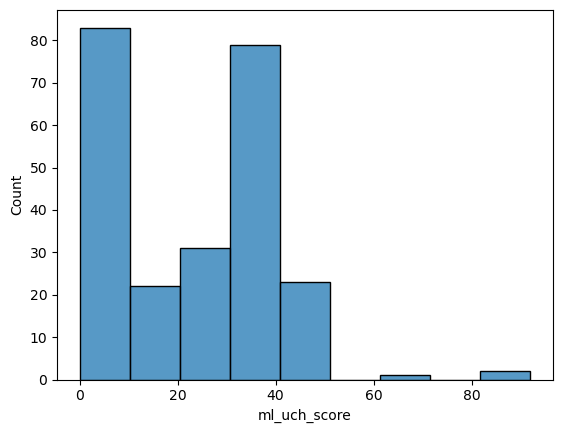

In [108]:
sns.histplot(data=unpaid_orders, x="ml_uch_score")


Second query, to get aggregate metrics per dynamic session level

In [128]:
query_2 = '''

WITH orders_count AS(

    SELECT 
        data__dynamic_session_id,
        event_time,
        ROW_NUMBER() OVER (PARTITION BY "data__dynamic_session_id" ORDER BY "event_time" DESC) AS row_number,
        COUNT("data__order_id") OVER (PARTITION BY "data__dynamic_session_id") AS order_count,
        o.order_id,
        p.payment_method,
        p.payment_status,
        p.amount_paid,
        o.customer_id,
        o.order_transacted_value_eur,
        o.order_cancel_reason,
        rfs.ml_uch_score as ml_score

    FROM "sensitive_delta"."central_risk_engine_odp"."risk_feature_snapshots_enhanced" AS rfs

    INNER JOIN  "sensitive_delta"."central_checkout_orders_odp"."checkout_orders" AS co ON rfs.checkout_id = co.checkout_id
    INNER JOIN  "delta"."central_order_descriptors_odp"."order_descriptors_v2" AS o ON co.order_id = o.order_id
    INNER JOIN  legacy_lake.refinery_kinesis.backend_checkout_order_created_event AS be ON o.order_id = be.data__order_id
    INNER JOIN "delta"."fintech_payments_odp"."payments" AS p ON o.order_id = p.order_id

    WHERE 
        p_event_date >= DATE '2023-05-01'
        AND "data__country" = 'RO'
        AND p.payment_method = 'CASH'
        and data__dynamic_session_id is not null
)

SELECT
    data__dynamic_session_id,
    customer_id,
    sum(case when payment_status = 'NOT_PAID' then 1 else 0 end) as unpaids,
    sum(case when payment_status = 'NOT_PAID' then orders_count.order_transacted_value_eur else 0 end) as amount_unpaids,
    max(order_count) as max_orders,
    sum(case when orders_count.payment_status = 'NOT_PAID' then 1 else 0 end)*100/cast(max(order_count) as real) as unpaid_rate,
    avg(ml_score) as avg_ml_score
    
    --group by dynamic session and customer
FROM orders_count
WHERE order_count > 2 and order_count < 30
group by 1,2

'''

In [129]:
%%time
df2 = get_starburst_data_from_sql(query_2)

CPU times: user 281 ms, sys: 87.4 ms, total: 368 ms
Wall time: 24.2 s


In [130]:
df2 

,data__dynamic_session_id,customer_id,unpaids,amount_unpaids,max_orders,unpaid_rate,avg_ml_score
0,CFC05472-E6A9-4BA2-8FCF-49EFFF634E63,126714401,0,0.0,3,0.0,20.666667
1,E10CFD56-D902-451D-8F0C-7992A6DB306F,20058581,0,0.0,3,0.0,0.000000
2,E3E3CAA9-D93C-4474-8EE6-997D3CEE3296,45104285,0,0.0,3,0.0,0.000000
3,7C82D6A1-24B6-41FF-8B45-E29D7A5D493E,84639518,0,0.0,3,0.0,0.000000
4,25ed7299-318c-4f6b-9c93-1b7456b62e68,126359609,0,0.0,7,0.0,0.000000
...,...,...,...,...,...,...,...
2308,1bf6776a-0309-4ccf-8cb3-23ca374d3d9a,142101504,0,0.0,3,0.0,0.000000
2309,313BF352-D978-433D-947A-646BC89818F0,55052570,0,0.0,4,0.0,0.000000
2310,a1193896-ea9d-4b1c-b9da-2f1323479900,137466756,0,0.0,3,0.0,0.000000
2311,122D8A08-9216-4A3A-BE89-3F1333E721D4,24405089,0,0.0,4,0.0,0.000000


In [131]:
df2.sort_values(by=['unpaid_rate'], ascending=False).head(20)

,data__dynamic_session_id,customer_id,unpaids,amount_unpaids,max_orders,unpaid_rate,avg_ml_score
1416,8f7c97e8-a7fb-4fd7-9ce0-a72adaa6348e,147032120,3,64.049226,3,100.000000,27.000000
9,7AA528CC-4E57-4B0E-A6B3-D8BA23162BC0,145382979,3,164.983776,3,100.000000,36.666667
752,c09292e1-06ea-4d78-96b2-97026d108bb3,147031986,3,62.770095,3,100.000000,23.333333
1277,16bcae45-200f-446f-ae3a-bbac27a91f19,146584740,4,178.672495,4,100.000000,34.750000
881,f763f165-4dc4-48eb-b752-81112fd0d012,36041256,4,40.400005,4,100.000000,0.500000
1129,BA768C3B-7A25-4DD4-985D-07B3310059D8,141637132,3,46.372970,3,100.000000,6.000000
884,8920112e-ded7-44a2-81c4-92b0fcdb19d1,144279303,3,79.137330,3,100.000000,10.000000
1783,382A6D0F-1DF6-4D87-8FD9-68712F90B522,146294443,3,165.321677,4,75.000000,35.250000
1609,818d6959-1a75-46ff-95ad-71b317c8ac59,147289211,3,90.534709,4,75.000000,20.000000
2259,194fc0bf-1916-4f21-bee6-16758e8f0b37,147331599,3,50.660347,4,75.000000,9.500000


The average unpaid rate for number of orders in dynamic session

In [119]:
orders = df2.groupby('max_orders')['unpaid_rate'].mean().reset_index()
orders.head()

,max_orders,unpaid_rate
0,3,1.829268
1,4,4.393305
2,5,2.941176
3,6,4.365079
4,7,0.000000


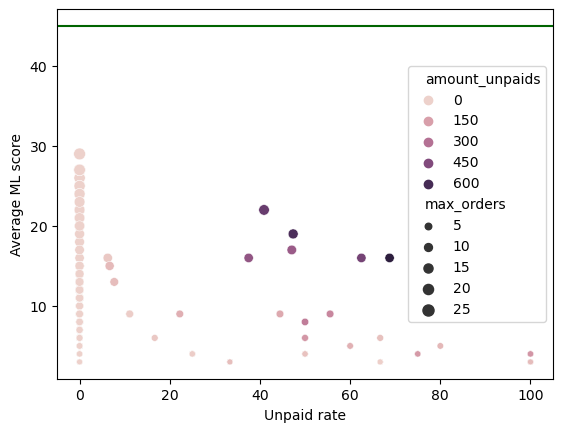

In [115]:
sns.scatterplot(data=df2, x="unpaid_rate", y="max_orders", size="max_orders", hue ='amount_unpaids')
plt.xlabel("Unpaid rate")
plt.ylabel("Average ML score")
plt.axhline(y = 45, color = 'darkgreen')



Every dot represents a unique dynamic session

In [132]:
scores = df[df['ml_uch_score'] > 15]
scores.head()

,data__dynamic_session_id,event_time,row_number,order_count,order_id,payment_method,payment_status,amount_paid,customer_id,order_transacted_value_eur,order_cancel_reason,ml_uch_score,paid_status
58,ff4e4372-82b9-4961-8d84-ebe0e2decc08,2023-05-26 22:07:24.685000+00:00,1,3,627308054,CASH,NOT_PAID,0,146919130,10.279278,USER_ERROR,29.0,1
59,ff4e4372-82b9-4961-8d84-ebe0e2decc08,2023-05-26 21:25:00.805000+00:00,2,3,627295996,CASH,NOT_PAID,0,146919130,9.872058,CUSTOMER_ABSENT,33.0,1
60,ff4e4372-82b9-4961-8d84-ebe0e2decc08,2023-05-26 21:15:24.291000+00:00,3,3,627291619,CASH,PAID,0,146919130,0.000000,USER_ERROR,30.0,0
83,1F345E2D-61D9-462F-A39F-A14D978CB3E2,2023-05-14 15:49:58.610000+00:00,1,4,619672892,CASH,NOT_PAID,0,146352688,70.465582,CUSTOMER_ABSENT,34.0,1
84,1F345E2D-61D9-462F-A39F-A14D978CB3E2,2023-05-14 15:26:44.203000+00:00,2,4,619655546,CASH,PAID,0,146350895,0.000000,CUSTOMER_ABSENT,41.0,0


In [135]:
scores[scores['payment_status']=='NOT_PAID'].order_transacted_value_eur.sum()

6379.987895509999

In [133]:
precision = len(scores[scores['payment_status'] == 'NOT_PAID'])/len(scores)
precision

0.17936117936117937

If we had this threshold, we would have an estimated precision of around 20%, which is fine.. because not allowing a customer to order quickly is kind of understandable .. its also a soft block, so they can order with card, and if they just wait for order, they can order again later.. this precision is also much higher than break even precision , so we would be saving money if we blocked more multi cash orders (Romania specicially)

<AxesSubplot:xlabel='max_orders', ylabel='unpaid_rate'>

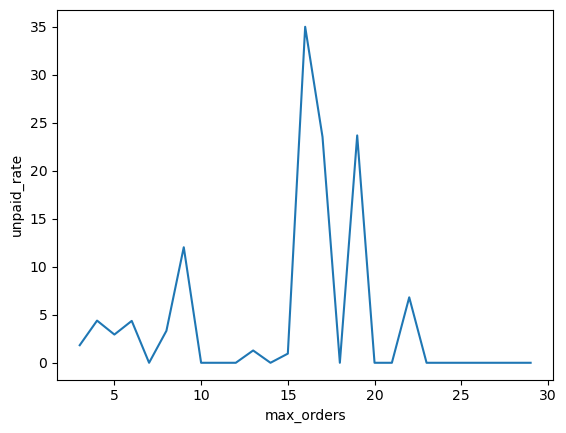

In [124]:
sns.lineplot(data=orders, x = 'max_orders', y = 'unpaid_rate')